In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [3]:
# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [4]:
# Read dataset & Preprocess text
# dataset = pd.read_csv('../input/isear-emotion/isear_dataset.csv')
df_train = pd.read_csv("C:/Users/velag/Downloads/archive (9)/train.txt", names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv("C:/Users/velag/Downloads/archive (9)/val.txt", names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv("C:/Users/velag/Downloads/archive (9)/test.txt", names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

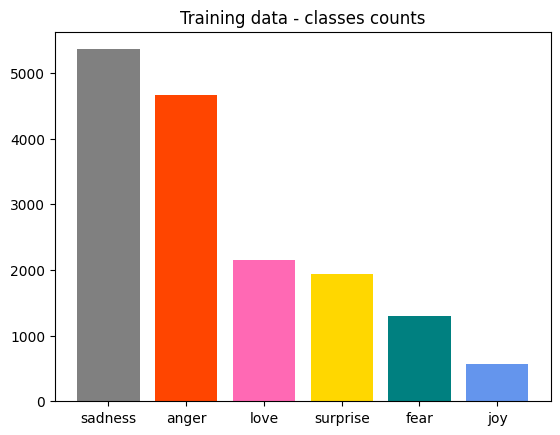

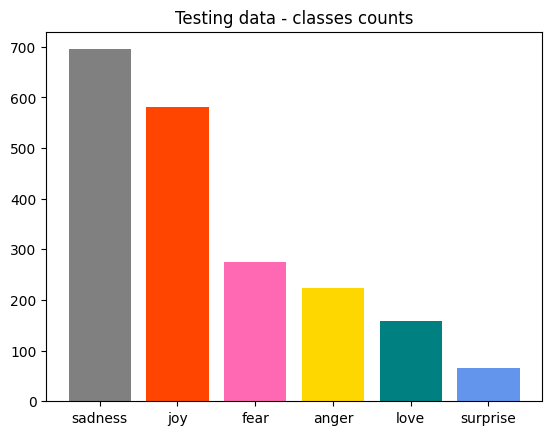

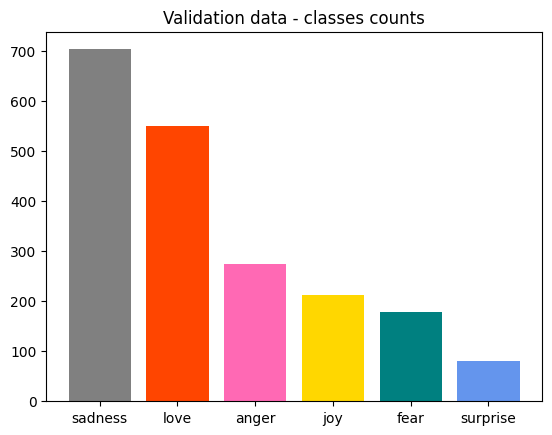

In [5]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [6]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [7]:

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [8]:
# Read GloVE embeddings

path_to_glove_file = "C:/Users/velag/Downloads/archive (10)/glove.6B.200d.txt"
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [9]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3237000   
                                                                 
 bidirectional (Bidirection  (None, 256, 512)          935936    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                       

In [10]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [11]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10


63/63 [==============================] - 3965s 63s/step - loss: 1.5141 - accuracy: 0.4046 - val_loss: 1.2380 - val_accuracy: 0.5475
Epoch 2/10
63/63 [==============================] - 5350s 85s/step - loss: 1.1693 - accuracy: 0.5612 - val_loss: 1.0401 - val_accuracy: 0.5925
Epoch 3/10
63/63 [==============================] - 73065s 1177s/step - loss: 0.8527 - accuracy: 0.6814 - val_loss: 0.5618 - val_accuracy: 0.7995
Epoch 4/10
63/63 [==============================] - 4642s 74s/step - loss: 0.4423 - accuracy: 0.8414 - val_loss: 0.2829 - val_accuracy: 0.9040
Epoch 5/10
63/63 [==============================] - 10908s 175s/step - loss: 0.2475 - accuracy: 0.9094 - val_loss: 0.2288 - val_accuracy: 0.9170
Epoch 6/10
63/63 [==============================] - 6429s 102s/step - loss: 0.1865 - accuracy: 0.9254 - val_loss: 0.2000 - val_accuracy: 0.9250
Epoch 7/10
63/63 [==============================] - 20871s 335s/step - loss: 0.1551 - accuracy: 0.9343 - val_loss: 0.2149 - val_accura

In [11]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 43s 681ms/step - loss: 0.1378 - accuracy: 0.9335


[0.13783422112464905, 0.9334999918937683]

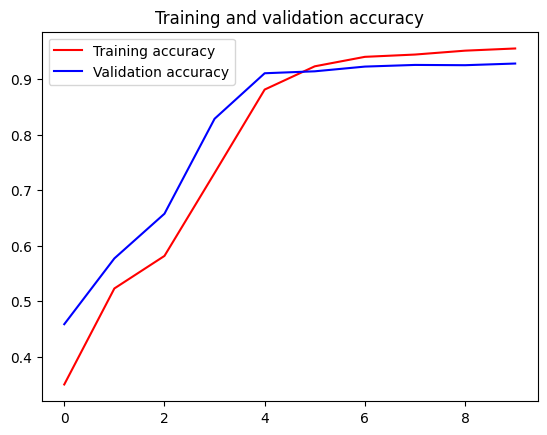

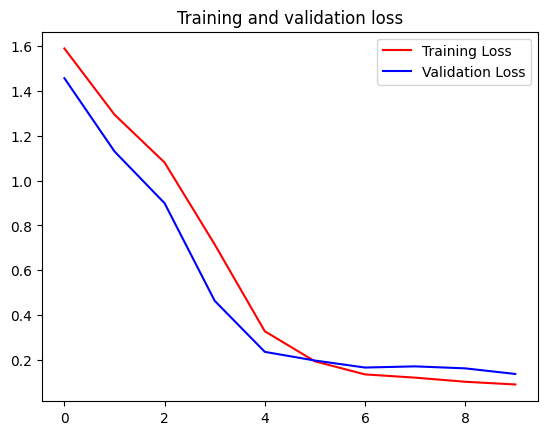

In [12]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')

C:\Users\velag\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
import re
import string
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load tokenizer and label encoder
with open('tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

with open('labelEncoder.pickle', 'rb') as f:
    le = pickle.load(f)

# Load the trained model
model = load_model('Emotion Recognition.h5')

# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text

def predict_emotion(text):
    cleaned_text = clean(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=256, truncating='pre')
    prediction = model.predict(padded_sequence)
    predicted_label = le.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Test some sample sentences
sample_sentences = [
    "I feel so happy today!",
    "This is really sad news.",
    "I'm so angry right now!",
    "I feel anxious about the upcoming exam.",
    "I'm feeling calm and relaxed.",
    "This movie made me feel afraid."
]

for sentence in sample_sentences:
    predicted_emotion = predict_emotion(sentence)
    print(f"Sentence: '{sentence}' -- Predicted Emotion: {predicted_emotion}")


1/1 [==============================] - 0s 264ms/step
{'anger': 0.03663595331204306, 'disgust': 0.008409774478195686, 'fear': 0.9394274652004242, 'joy': 0.0064006543971117935, 'sadness': 0.007856502346839989, 'surprise': 0.0012696317226073006}
<class 'dict'>
Average Emotion Probabilities:
anger: 0.0366
disgust: 0.0084
fear: 0.9394
joy: 0.0064
sadness: 0.0079
surprise: 0.0013
